In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
from dataclasses import dataclass
from typing import Any, Iterable

In [146]:
# replace with `--root_output_dir` used in the experiments
ROOT_OUTPUT_DIR = 'output'
RESULTS_DIR = f'{ROOT_OUTPUT_DIR}/results'

In [147]:
def read_result(expr_file, metric_col_name):
    return pd.read_csv(expr_file, usecols=[metric_col_name], squeeze=True).rolling(200).mean()

In [148]:
@dataclass
class Task:
    title: str
    metric_col_name: str

STYLES = {
    'Float32': {'style': 'k-o'},
    'H-SQ': {'style': 'b-.x'},
    'K-SQ': {'style': 'r:>'},
    'EDEN': {'style': 'C8-.v'}, 
    'QSGD': {'style': 'C9--.'},
    'QUIC_FL': {'style': 'g--*'},
}

METHOD_NAMES = {
    'Float32': 'Float32',
    'H-SQ': 'Hadamard',
    'K-SQ': 'Kashin-TF',
    'EDEN': 'EDEN',
    'QUIC_FL': 'QUIC-FL',
    'QSGD': 'QSGD',
}
    
@dataclass
class Expr:
    display_name: str
    name: str
    series: Any = None
    
    @property
    def style(self):
        return STYLES[self.display_name]
        
@dataclass
class Plot:
    task: Task
    exprs: Iterable[Expr]
    zoom_range: Any = None

In [149]:
EMNIST = Task('EMNIST', 'sparse_categorical_accuracy')
SHAKESPEARE = Task('Shakespeare', 'client_work/train/accuracy')

In [178]:
PLOT_META = [
    # 1 b
    [ Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.55, 0.605)), exprs=[Expr('Float32', 'shakespeare_no_compression'), Expr('H-SQ', 'shakespeare_hadamard_sq1'), Expr('K-SQ', 'b_shakespeare_kashin1'), Expr('QSGD', 'shakespeare_qsgd_2s'), Expr('EDEN', 'shakespeare_eden1'), Expr('QUIC_FL', 'shakespeare_quic_fl1')]) ], 
    # 2 b
    [ Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.581, 0.60)), exprs=[Expr('Float32', 'shakespeare_no_compression'), Expr('H-SQ', 'shakespeare_hadamard_sq2'), Expr('K-SQ', 'b_shakespeare_kashin2'), Expr('QSGD', 'shakespeare_qsgd_4s'), Expr('EDEN', 'shakespeare_eden2'), Expr('QUIC_FL', 'shakespeare_quic_fl2')]) ], 
    # 3 b
    [ Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.593, 0.60)), exprs=[Expr('Float32', 'shakespeare_no_compression'), Expr('H-SQ', 'shakespeare_hadamard_sq3'), Expr('K-SQ', 'b_shakespeare_kashin4'), Expr('QSGD', 'shakespeare_qsgd_8s'), Expr('EDEN', 'shakespeare_eden3'), Expr('QUIC_FL', 'shakespeare_quic_fl3')]) ], 
    # 4 b
    [ Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.5946, 0.5998)), exprs=[Expr('Float32', 'shakespeare_no_compression'), Expr('H-SQ', 'shakespeare_hadamard_sq4'), Expr('K-SQ', 'b_shakespeare_kashin4'), Expr('QSGD', 'shakespeare_qsgd_16s'), Expr('EDEN', 'shakespeare_eden3'), Expr('QUIC_FL', 'shakespeare_quic_fl4')]) ], 
]

In [179]:
for row in PLOT_META:
    for p in row:
        for e in p.exprs:
            expr_file = f'{RESULTS_DIR}/{e.name}/experiment.metrics.csv'
            if os.path.isfile(expr_file):
                try:
                    e.series = read_result(expr_file, p.task.metric_col_name)
                except:
                    print(f'got an error while reading experiment {e.name}')
            else:
                print(f'missing experiment: {e.name}')

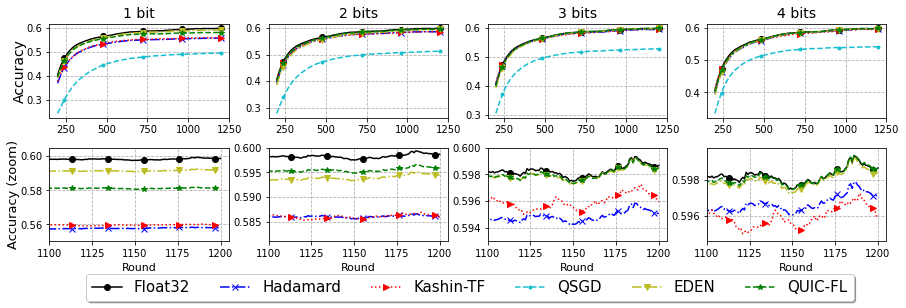

In [188]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

fig, axs = plt.subplots(2, 4, figsize=(15, 4),  gridspec_kw={'hspace': 0.32, 'wspace': 0.22})
acc_label_offset = [0]* 5
bits_label = ['1 bit', '2 bits', '3 bits', '4 bits']

PLOT_META_T = [[PLOT_META[c][0] for c in range(4)] for r in range(2)]
for row, (r_axs, r_meta) in enumerate(zip(axs, PLOT_META_T)):
    if row == 0:
        r_axs[0].set_ylabel('Accuracy', fontsize=14, labelpad=acc_label_offset[row])
    else:
        r_axs[0].set_ylabel('Accuracy (zoom)', fontsize=13, labelpad=acc_label_offset[row])
    
    for col, (ax, meta) in enumerate(zip(r_axs, r_meta)):
        if row == 0:
            ax.set_title(bits_label[col], fontsize=14)
            x_range = meta.exprs[0].series.size
        else:
            ax.set_xlim(meta.zoom_range[0])
            ax.set_ylim(meta.zoom_range[1])
            x_range = (meta.zoom_range[0][1] - meta.zoom_range[0][0])
        
        markevery=max(x_range // 5, 1)
        for e in meta.exprs:
            if e.series is not None:
                e.series.plot(ax=ax, **e.style, legend=False, label=METHOD_NAMES[e.display_name], markevery=markevery)
            else:
                print(f'missing series {e.name}')
        ax.grid(linestyle='dashed')

for ax in axs[-1]:
    ax.set_xlabel('Round', fontsize=11)
handles, labels = axs[0][-1].get_legend_handles_labels()
        
axs[1][2].legend(handles=handles,  # The line objects
                  labels=labels,  # The labels for each line
                   loc="lower center",  # Position of legend
                   bbox_to_anchor=(-0.10, -0.65),
                   borderaxespad=0.1,  # Small spacing around legend box
                   shadow=True,
                   ncol=6,
                   fontsize=15)

fig.savefig(f'plots/shakespeare2.pdf', bbox_inches='tight')